In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
plays = pd.read_csv('nfl_data/plays_new.csv', sep='\t', index_col=0).drop(['playDescription', 'timeToSack'], axis=1)


In [3]:
players =  pd.read_csv('nfl_data/players.csv')
players = players.drop(['height', 'weight', 'birthDate', 'collegeName', 'displayName'], axis=1)

In [4]:
pp =  pd.read_csv('nfl_data/player_play.csv').drop(['penaltyNames', 'penaltyYards'], axis=1)

In [5]:
pp['wasRunningRoute'] = pp['wasRunningRoute'].fillna(0).astype(int)

In [10]:


# week = pd.read_csv('nfl_data/tracking_week_1.csv')


week = pd.read_csv('nfl_data/tracking_week_1.csv')
week2 = pd.read_csv('nfl_data/tracking_week_2.csv')
week3 = pd.read_csv('nfl_data/tracking_week_3.csv')
week4 = pd.read_csv('nfl_data/tracking_week_4.csv')
week5 = pd.read_csv('nfl_data/tracking_week_5.csv')
week6 = pd.read_csv('nfl_data/tracking_week_6.csv')
week7 = pd.read_csv('nfl_data/tracking_week_7.csv')
week8 = pd.read_csv('nfl_data/tracking_week_8.csv')
week9 = pd.read_csv('nfl_data/tracking_week_9.csv')



**wasRunningRoute** hadRushAttempt hadPassReception wasTargettedReceiver yardageGainedAfterTheCatch receivingYards fumbles forcedFumbleAsDefense (CB) soloTackle tackleAssist hadInterception pff_runConceptPrimary receiverAlignment  routeRan

In [11]:
week1 = pd.concat([week,week2,week3,week4,week5,week6,week7])

In [12]:
for i in [week,week2,week3,week4,week5,week6,week7]:
    del i
    gc.collect()

In [13]:
# Gameplays with forward pass

pass_forward = week1.query('event=="pass_forward"')[['gameId','playId']].drop_duplicates()

In [14]:
pp = pp.merge(pass_forward, on=['gameId','playId'], how='inner')
plays = plays.merge(pass_forward, on=['gameId','playId'], how='inner')

In [15]:
plays.query('passResult=="NoPass"')[['dropbackType', 'passResult','passLength', 'targetX', 'targetY']]#.loc[239]

,dropbackType,passResult,passLength,targetX,targetY
391,UNKNOWN,NoPass,0.0,NaN,NaN
1505,UNKNOWN,NoPass,0.0,NaN,NaN
1563,UNKNOWN,NoPass,0.0,NaN,NaN
2484,UNKNOWN,NoPass,0.0,NaN,NaN
3034,UNKNOWN,NoPass,0.0,NaN,NaN
4434,UNKNOWN,NoPass,0.0,NaN,NaN
5111,UNKNOWN,NoPass,0.0,NaN,NaN
5450,UNKNOWN,NoPass,0.0,NaN,NaN
5669,UNKNOWN,NoPass,0.0,NaN,NaN
5780,UNKNOWN,NoPass,0.0,NaN,NaN


In [16]:
plays = plays.query('passResult!="NoPass"')

In [17]:
pp = pp.merge(plays, on=['gameId', 'playId']).merge(players[['position', 'nflId']], on='nflId', how='left')

In [18]:
len(pp.query('qbSpike==1 or qbKneel==1'))

0

In [19]:
pp = pp.drop(['qbSpike', 'qbKneel', 'dropbackDistance', 'penalty', 'hadDropback', 'timeToPressureAsPassRusher', 
              'sackYardsAsOffense', 'absoluteYardlineNumber'], axis=1) # 'isDropback', 

In [20]:
# week1.query('event.isin(["shift", "man_in_motion"])')

In [21]:
week1 = week1.merge(pass_forward, on=['gameId','playId'], how='inner')

In [22]:
# week1 = week.copy()

week1 = week1.query('~nflId.isna()')

week1['time'] = pd.to_datetime(week1['time'], errors='coerce')
 
week1 = week1.sort_values(['gameId', 'playId', 'nflId', 'frameId'])
week1['event'] = week1.groupby(['gameId', 'playId', 'nflId'])['event'].ffill()

# week1
week1['dx'] = week1.groupby(['gameId', 'playId', 'nflId'])['x'].diff().fillna(0)
week1['dy'] = week1.groupby(['gameId', 'playId', 'nflId'])['y'].diff().fillna(0)
week1['displacement'] = (week1['dx']**2 + week1['dy']**2)**0.5


# week1 = week1.merge(plays[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'], how='left')
# week1['isOffense'] = week1['club'] == week1['possessionTeam']
# week1 = week1.drop('possessionTeam', axis=1)

week1 = week1.merge(players[players['position'].isin(['WR', 'CB'])][['nflId','position']], on='nflId', how='inner')

In [23]:
week1 = week1.drop(['displayName', 'jerseyNumber'], axis=1)

Now this df consists of CB and WR.

In [24]:
# pp[pp['shiftSinceLineset']==True]['position'].unique()

In [25]:
before = week1[week1['frameType'] == 'BEFORE_SNAP']#.tail(frames_before)
# snap = week1[week1['frameType'] == 'SNAP']#.tail(frames_before)
# after = week1[week1['frameType'] == 'AFTER_SNAP']#.head(frames_after)

In [ ]:
# del players
# del plays

In [26]:
# exclude plays where the receiver did not run a route at all to focus on "active" WRs who are potential pass targets.
pp = pp.query('~(position=="WR" and wasRunningRoute!=1)')

Don't exclude plays where the WR wasn't targeted because the CB doesn't know whether the pass will go to their WR.

## Games and plays where all WRs moved before the snap are referred to as moved.

In [27]:
# player play with the shiftSinceLineset or motionSinceLineset
linesetShift = pp[( (pp['shiftSinceLineset']==True) | ((pp['motionSinceLineset']==True)) ) & (pp['position']=="WR")][['gameId', 'playId']].drop_duplicates()


In [31]:
# gameplay pairs where WR moved before snap according to the event column

WR_moved = before[before['event'].isin(['man_in_motion', 'shift']) & (before['position']=="WR")][['gameId', 'playId']].drop_duplicates()
WR_moved.head(2)

,gameId,playId
616,2022090800,569
977,2022090800,617


In [32]:
# Either event or shiftSinceLineset

WR_moved = WR_moved.merge(linesetShift, on=['gameId', 'playId'], how='outer')

In [33]:
week1_move = week1.merge(WR_moved, on=['gameId', 'playId'])


In [34]:
# week1[week1.set_index(['gameId', 'playId']).index.isin(
#         WR_moved.set_index(['gameId', 'playId']).index)][['gameId', 'playId']].drop_duplicates().reset_index(drop=True)


In [35]:

week1_nomove = week1[~week1.set_index(['gameId', 'playId']).index.isin(WR_moved.set_index(['gameId', 'playId']).index)] #[['gameId', 'playId']].drop_duplicates()


In [36]:
WR_NOmoved = week1_nomove[['gameId', 'playId']].drop_duplicates() # gameplay pairs

In [37]:
# before = before.merge(WR_moved, on=['gameId', 'playId'])
# snap = snap.merge(WR_moved, on=['gameId', 'playId'])
# after = after.merge(WR_moved, on=['gameId', 'playId'])

In [38]:
# MAN_cov = plays[plays['pff_manZone']=='Man'][['gameId', 'playId']].drop_duplicates()
# Zone_cov = plays[plays['pff_manZone']=='Zone'][['gameId', 'playId']].drop_duplicates()

# pp_man = pp.query('pff_defensiveCoverageAssignment=="MAN"')[['gameId', 'playId']].drop_duplicates()
# pp_zone = pp.query('pff_defensiveCoverageAssignment!="MAN"')[['gameId', 'playId']].drop_duplicates()

# man_plays = MAN_cov.merge(pp_man, on=['gameId', 'playId'], how='inner')
# zone_plays = Zone_cov.merge(pp_zone, on=['gameId', 'playId'], how='outer')

In [39]:
display(pp.query('pff_manZone=="Man" and pff_defensiveCoverageAssignment.isna()')[['pff_manZone','pff_defensiveCoverageAssignment']].head())
display(pp.query('pff_manZone=="Zone" and pff_defensiveCoverageAssignment.isna()')[['pff_manZone','pff_defensiveCoverageAssignment']].head())

,pff_manZone,pff_defensiveCoverageAssignment
66,Man,NaN
67,Man,NaN
68,Man,NaN
69,Man,NaN
70,Man,NaN


,pff_manZone,pff_defensiveCoverageAssignment
0,Zone,NaN
1,Zone,NaN
2,Zone,NaN
3,Zone,NaN
4,Zone,NaN


In [40]:
pp['pff_defensiveCoverageAssignment'] = pp['pff_defensiveCoverageAssignment'].where(pp['pff_defensiveCoverageAssignment'].notna(),
        pp['pff_manZone'].map({'Man': 'MAN', 'Zone': 'ZONE'}))

In [41]:
pp.loc[68][['pff_manZone','pff_defensiveCoverageAssignment']]

pff_manZone                        Man
pff_defensiveCoverageAssignment    MAN
Name: 68, dtype: object

In [42]:
pp.loc[2][['pff_manZone','pff_defensiveCoverageAssignment']]

pff_manZone                        Zone
pff_defensiveCoverageAssignment    ZONE
Name: 2, dtype: object

In [43]:
pp.pff_defensiveCoverageAssignment.unique()

array(['ZONE', 'HCR', '4OR', 'FL', 'CFR', '4IR', '2L', 'HCL', 'CFL', '3L',
       'HOL', '3R', '3M', 'MAN', 'DF', '2R', 'FR', '4OL', '4IL', nan,
       'PRE'], dtype=object)

In [44]:
pp = pp[pp['pff_manZone'].notna()]

In [45]:
# player play data for zone and man

zone = pp.query('pff_defensiveCoverageAssignment!="MAN" and position.isin(["CB", "WR"])')
man = pp.query('pff_defensiveCoverageAssignment=="MAN" and position.isin(["CB", "WR"])')

In [46]:
zone_plays_move = WR_moved.merge(zone, on=['gameId', 'playId'], how='inner') # before snap 
man_plays_move = WR_moved.merge(man, on=['gameId', 'playId'], how='inner') # before snap

In [47]:
zone_plays_nomove = WR_NOmoved.merge(zone, on=['gameId', 'playId'], how='inner')
man_plays_nomove = WR_NOmoved.merge(man, on=['gameId', 'playId'], how='inner')

# Man analysis

In [48]:
# # Tracking data
# before_man = before.merge(man_plays[['gameId', 'playId']].drop_duplicates(), on=['gameId', 'playId'])
# snap_man = snap.merge(man_plays[['gameId', 'playId']].drop_duplicates(), on=['gameId', 'playId'])
# after_man = after.merge(man_plays[['gameId', 'playId']].drop_duplicates(), on=['gameId', 'playId'])

## 1.1 WR Did NOT Move Before Snap

In [49]:
# players play data man no move
man_plays_nomove.head(2)

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,passingYards,hadPassReception,receivingYards,wasTargettedReceiver,...,yardsGained,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,distanceFromOwnEndZone,passAfterScramble,position
0,2022090800,1126,42489,BUF,0,0,0,0,0,0,...,0,1,UNKNOWN,UNKNOWN,0,Cover-1,Man,77,0,WR
1,2022090800,1126,44985,BUF,0,0,0,0,0,0,...,0,1,UNKNOWN,UNKNOWN,0,Cover-1,Man,77,0,WR


In [50]:
# Man tracking data no movement

man_week_nomove= week1_nomove.query('frameType!="BEFORE_SNAP"').merge(man_plays_nomove[['gameId', 'playId']].drop_duplicates(), on=['gameId', 'playId'])


In [51]:
man_week_nomove.head(2)

,gameId,playId,nflId,frameId,frameType,time,club,playDirection,x,y,s,a,dis,o,dir,event,dx,dy,displacement,position
0,2022090800,1126,42489.0,133,SNAP,2022-09-09 01:04:30.800,BUF,right,86.06,20.35,0.15,1.71,0.01,75.29,79.73,ball_snap,0.01,0.00,0.010000,WR
1,2022090800,1126,42489.0,134,AFTER_SNAP,2022-09-09 01:04:30.900,BUF,right,86.09,20.36,0.46,2.83,0.03,75.29,79.81,ball_snap,0.03,0.01,0.031623,WR


In [52]:
# def aggregation_per_second(df, pos, when):    
    
#     temp = df.query('position==@pos and frameType== @when').copy()

#     temp['frame_group'] = (temp.groupby(['gameId', 'playId', 'nflId']).cumcount() // 10)

#     aggregated = temp.groupby(['gameId', 'playId', 'nflId', 'frame_group']).agg(
#         x_start=('x', 'first'),  
#         y_start=('y', 'first'),
#         x_end=('x', 'last'),
#         y_end=('y', 'last')
#     ).reset_index()

#     aggregated['dx'] = aggregated['x_end'] - aggregated['x_start']
#     aggregated['dy'] = aggregated['y_end'] - aggregated['y_start']

#     aggregated['displacement'] = (aggregated['dx']**2 + aggregated['dy']**2)**0.5

# #     display(aggregated.head())
#     display(aggregated[['dx','dy','displacement']].describe())


# aggregation_per_second(man_week_nomove, "WR", "BEFORE_SNAP") # WR stats in man plays where WR did not move before snap in man plays

In [53]:
# aggregation_per_second(man_week_nomove, "CB", "BEFORE_SNAP") # CB stats in man plays where WR moved before snap in man plays


In [54]:

man_plays_nomove.query('pff_primaryDefensiveCoverageMatchupNflId.notna()')[['gameId','playId','nflId', 'position', 
                                                                     'pff_primaryDefensiveCoverageMatchupNflId']].head()

,gameId,playId,nflId,position,pff_primaryDefensiveCoverageMatchupNflId
3,2022090800,1126,42816,CB,52536.0
4,2022090800,1126,43294,CB,44985.0
5,2022090800,1126,47862,CB,47879.0
9,2022090800,1563,42816,CB,44985.0
10,2022090800,1563,43294,CB,42489.0


In [55]:
def create_matchup(plays_data, weeks):
    """
    plays_data: plays data (man/zone, moved/did not move)
    weeks: tracking data (man/zone, moved/did not move)
    """
    
    matchup = plays_data.query('position=="CB"')[['gameId', 'playId', 'nflId', 'position', 
                     'pff_primaryDefensiveCoverageMatchupNflId']].dropna().drop(columns=['position'])

    matchup = matchup.rename(columns={'nflId': 'CBid', 'pff_primaryDefensiveCoverageMatchupNflId': 'WRid'})

    wr_man = weeks[weeks['position'] == "WR"]
    wr_man = wr_man.merge(matchup, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'WRid'], how='inner')

    cb_man = weeks[weeks['position'] == "CB"]
    cb_man = cb_man.merge(matchup, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'CBid'], how='inner')


    cb_wr_track = wr_man.drop('nflId', axis=1).merge(
                                                cb_man.drop('nflId', axis=1),
                                                on=['gameId', 'playId', 'frameId', 'CBid', 'WRid'], 
                                                how='inner',
                                                suffixes=('_wr', '_cb')).drop(['frameType_cb', 'time_cb', 'event_cb'], axis=1)
    
    
    cb_wr_track = cb_wr_track.rename(columns={'frameType_wr': 'frameType', 'time_wr': 'time', 'event_wr': 'event'})

    cb_wr_track['distance'] = ((cb_wr_track['x_wr'] - cb_wr_track['x_cb'])**2 + 
                               (cb_wr_track['y_wr'] - cb_wr_track['y_cb'])**2)**0.5

    return cb_wr_track

In [56]:
man_nomove_matchaup = create_matchup(man_plays_nomove, man_week_nomove)

In [57]:

# matchap_nomove = man_plays_nomove.query('position=="CB"')[['gameId', 'playId', 'nflId', 'position', 
#                      'pff_primaryDefensiveCoverageMatchupNflId']].dropna().drop(columns=['position'])

# matchap_nomove = matchap_nomove.rename(columns={'nflId': 'CBid', 'pff_primaryDefensiveCoverageMatchupNflId': 'WRid'})




# wr_man = week1_NoMove_man[week1_NoMove_man['position'] == "WR"]
# wr_man = wr_man.merge(matchap_nomove, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'WRid'], how='inner')

# cb_man = week1_NoMove_man[week1_NoMove_man['position'] == "CB"]
# cb_man = cb_man.merge(matchap_nomove, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'CBid'], how='inner')

# # В wr_tracking у нас данные WR, а в cb_tracking — данные CB, которые их прикрывают
# display(wr_man.head())
# display(cb_man.head())



# cb_wr_track = wr_man.drop('nflId', axis=1).merge(
#     cb_man.drop('nflId', axis=1),
#     on=['gameId', 'playId', 'frameId', 'CBid', 'WRid'], 
#     how='inner',
#     suffixes=('_wr', '_cb')).drop(['frameType_cb', 'time_cb', 'event_cb'], axis=1)



# cb_wr_track = cb_wr_track.rename(columns={'frameType_wr': 'frameType', 'time_wr': 'time', 'event_wr': 'event'})

# # Distance between CB and WR
# cb_wr_track['distance'] = ((cb_wr_track['x_wr'] - cb_wr_track['x_cb'])**2 + 
#                            (cb_wr_track['y_wr'] - cb_wr_track['y_cb'])**2)**0.5

# cb_wr_track

In [58]:
man_nomove_matchaup.query('event.isin(["pass_forward", "pass_release", "pass_outcome_caught"])').groupby(['gameId', 'playId', 'event'])['distance'].mean()


gameId      playId  event              
2022090800  1126    pass_forward           1.766098
            1563    pass_forward           2.177457
                    pass_outcome_caught    1.749640
            1609    pass_forward           1.880512
            1836    pass_forward           1.334985
                                             ...   
2022102400  1754    pass_forward           1.894077
                    pass_outcome_caught    3.219953
            2513    pass_forward           3.716771
                    pass_outcome_caught    5.912040
            3623    pass_forward           1.433593
Name: distance, Length: 2248, dtype: float64

In [59]:
man_nomove_matchaup.event.unique()

array(['ball_snap', 'pass_forward', 'pass_outcome_incomplete',
       'pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
       'pass_outcome_interception', 'first_contact', 'tackle',
       'play_action', 'pass_outcome_touchdown', 'man_in_motion',
       'dropped_pass', 'touchdown', 'fumble', 'fumble_defense_recovered',
       'touchback', 'line_set', 'pass_tipped', 'shift',
       'fumble_offense_recovered', 'snap_direct', 'qb_strip_sack',
       'play_submit', 'handoff', 'lateral'], dtype=object)

In [60]:
def pass_events_results(matchup_data):

    pass_events = matchup_data.query('event.isin(["pass_forward", "pass_arrived", "pass_outcome_caught", "ball_snap"])')

    pass_events = pass_events.groupby(['gameId', 'playId', 'CBid', 'WRid', 'event']).agg(
        avg_dist=('distance', 'mean'), final_dist=('distance', 'first')).reset_index()

    pass_events = pass_events.pivot( index=['gameId', 'playId', 'CBid', 'WRid'], columns='event', values=['avg_dist', 'final_dist'])

    pass_events.columns = ['_'.join(col).strip() for col in pass_events.columns.values]
    pass_events.reset_index(inplace=True)


    # Each row represents unique pairs of gameplay, receiver ID, and cornerback ID, along with the average and final distances for specific actions.

    pass_events = pass_events.merge(
        pp[['gameId', 'playId', 'nflId', 'offenseFormation', 'hadPassReception', 'wasTargettedReceiver', 'passResult', 
            'yardsGained', 'receivingYards', 'yardageGainedAfterTheCatch', 'distanceFromOwnEndZone', 'routeRan', 'receiverAlignment']],
        left_on=['gameId', 'playId', 'WRid'], right_on = ['gameId', 'playId', 'nflId'],
        how='left')#.merge(pp)

    pass_events = pass_events.drop('nflId', axis=1)
    return pass_events

In [61]:
man_nomove_results = pass_events_results(man_nomove_matchaup)
man_nomove_results.head(2)

,gameId,playId,CBid,WRid,avg_dist_ball_snap,avg_dist_pass_arrived,avg_dist_pass_forward,avg_dist_pass_outcome_caught,final_dist_ball_snap,final_dist_pass_arrived,...,offenseFormation,hadPassReception,wasTargettedReceiver,passResult,yardsGained,receivingYards,yardageGainedAfterTheCatch,distanceFromOwnEndZone,routeRan,receiverAlignment
0,2022090800,1126,42816,52536.0,5.834207,NaN,1.151469,NaN,7.722545,NaN,...,SHOTGUN,0.0,1.0,I,0.0,0.0,0.0,77.0,OUT,3x1
1,2022090800,1126,43294,44985.0,5.138407,NaN,2.380726,NaN,6.890007,NaN,...,SHOTGUN,0.0,0.0,I,0.0,0.0,0.0,77.0,CROSS,3x1


In [81]:
man_plays_nomove['offenseFormation'].value_counts()

SHOTGUN       4934
EMPTY          929
SINGLEBACK     431
PISTOL          89
I_FORM          80
WILDCAT         11
JUMBO            4
Name: offenseFormation, dtype: int64

In [82]:
man_plays_nomove = man_plays_nomove.query('offenseFormation != "JUMBO"')

## 1.2 WR Moved Before Snap

In [83]:
man_plays_move.head(3)

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,passingYards,hadPassReception,receivingYards,wasTargettedReceiver,...,yardsGained,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,distanceFromOwnEndZone,passAfterScramble,position
0,2022090800,2733,43294,LA,0,0,0,0,0,0,...,0,1,UNKNOWN,UNKNOWN,0,Red Zone,Other,96,0,CB
1,2022091900,344,53451,TEN,0,0,0,0,0,0,...,11,1,POWER,UNKNOWN,0,Red Zone,Other,89,0,CB
2,2022091900,1798,42489,BUF,0,0,0,1,4,1,...,4,1,UNDEFINED,UNKNOWN,0,Cover-0,Man,96,0,WR


In [84]:
man_plays_move['offenseFormation'].value_counts()

SHOTGUN       3470
SINGLEBACK     761
EMPTY          682
I_FORM         147
PISTOL          89
WILDCAT          8
JUMBO            3
Name: offenseFormation, dtype: int64

In [85]:
man_plays_move = man_plays_move.query('offenseFormation != "JUMBO"')

In [86]:
# Take man.

man_week_move = week1_move.query('frameType!="BEFORE_SNAP"').merge(man_plays_move[['gameId', 'playId']].drop_duplicates(), on=['gameId', 'playId'])

In [87]:
man_plays_move.query('pff_primaryDefensiveCoverageMatchupNflId.notna()')[['gameId','playId','nflId', 'position', 
                                                                     'pff_primaryDefensiveCoverageMatchupNflId']].head()

,gameId,playId,nflId,position,pff_primaryDefensiveCoverageMatchupNflId
0,2022090800,2733,43294,CB,42489.0
1,2022091900,344,53451,CB,42489.0
5,2022091900,1798,52651,CB,42818.0
6,2022091900,1798,53451,CB,42489.0
7,2022091900,1798,54500,CB,47879.0


In [88]:
man_move_matchaup = create_matchup(man_plays_move, man_week_move)

In [89]:
man_move_matchaup.head(2)

,gameId,playId,frameId,frameType,time,club_wr,playDirection_wr,x_wr,y_wr,s_wr,...,s_cb,a_cb,dis_cb,o_cb,dir_cb,dx_cb,dy_cb,displacement_cb,position_cb,distance
0,2022090800,2733,121,SNAP,2022-09-09 02:28:22.700,BUF,right,105.05,13.31,0.02,...,0.01,0.01,0.01,270.03,125.14,0.00,-0.01,0.010000,CB,2.035534
1,2022090800,2733,122,AFTER_SNAP,2022-09-09 02:28:22.800,BUF,right,105.06,13.31,0.11,...,0.01,0.01,0.02,270.03,132.42,0.01,-0.02,0.022361,CB,2.034158


In [90]:
# # matchup = man_plays_move.query('position=="CB"')[['gameId', 'playId', 'nflId', 'position', 
# #                      'pff_primaryDefensiveCoverageMatchupNflId']].dropna()

# # matchup = matchup.rename(columns={'nflId': 'CBid', 'pff_primaryDefensiveCoverageMatchupNflId': 'WRid'})
# # matchup = matchup.drop(columns=['position'])


# # wr_man = man_week_move[man_week_move['position'] == "WR"]
# # wr_man = wr_man.merge(matchup, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'WRid'], how='inner')

# # cb_man = man_week_move[man_week_move['position'] == "CB"]
# # cb_man = cb_man.merge(matchup, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'CBid'], how='inner')
# # display(wr_man.head())
# # display(cb_man.head())


# # cb_wr_track = wr_man.drop('nflId', axis=1).merge(
# #     cb_man.drop('nflId', axis=1),
# #     on=['gameId', 'playId', 'frameId', 'CBid', 'WRid'], 
# #     how='inner',
# #     suffixes=('_wr', '_cb')).drop(['frameType_cb', 'time_cb', 'event_cb'], axis=1)

# cb_wr_track = cb_wr_track.rename(columns={'frameType_wr': 'frameType', 'time_wr': 'time', 'event_wr': 'event'})


# # Distance between CB and WR
# cb_wr_track['distance'] = ((cb_wr_track['x_wr'] - cb_wr_track['x_cb'])**2 + 
#                            (cb_wr_track['y_wr'] - cb_wr_track['y_cb'])**2)**0.5

In [91]:
# aggregation_per_second(man_week_move[man_week_move['event'].isin(['man_in_motion', 'shift'])], "CB")

In [94]:
# cb_wr_track.query('distance>3 and event.isin(["pass_forward", "pass_release", "pass_outcome_caught"])').groupby(['gameId', 'playId', 'event'])['distance'].mean()


In [95]:
# cb_wr_track.query('event=="pass_outcome_caught"')

In [96]:
# events = cb_wr_track[cb_wr_track['event'].isin(['pass_forward', 'pass_release', 'pass_catch'])]

# events.query('distance > 2').groupby(['gameId', 'playId', 'event']).agg(avg_distance=('distance', 'mean')).reset_index()


# events = cb_wr_track[cb_wr_track['event'].isin(['pass_forward', 'pass_outcome_caught'])]
# events

In [97]:
# pass_events = cb_wr_track.query('event.isin(["pass_forward", "pass_arrived", "pass_outcome_caught"])')

# pass_events = pass_events.groupby(['gameId', 'playId', 'CBid', 'WRid', 'event']).agg(
#     avg_dist=('distance', 'mean'), final_dist=('distance', 'first')).reset_index()

# pass_events = pass_events.pivot( index=['gameId', 'playId', 'CBid', 'WRid'], columns='event', values=['avg_dist', 'final_dist'])

# pass_events.columns = ['_'.join(col).strip() for col in pass_events.columns.values]
# pass_events.reset_index(inplace=True)

# pass_events

<!-- Каждая строка - уникальные пары геймплей, id ресивера и корнербэка, средние и финальные расстояния в том или ином действии.

Ниже добавим туда результат розыгрыша. -->

In [98]:
# pass_events = pass_events.merge(
#     pp[['gameId', 'playId', 'nflId', 'hadPassReception', 'wasTargettedReceiver', 'passResult', 'yardsGained', 'receivingYards', 'yardageGainedAfterTheCatch']],
#     left_on=['gameId', 'playId', 'WRid'], right_on = ['gameId', 'playId', 'nflId'],
#     how='left'
# )#.merge(pp)

# pass_events

In [99]:
man_move_results = pass_events_results(man_move_matchaup)
man_move_results.head(2)

,gameId,playId,CBid,WRid,avg_dist_ball_snap,avg_dist_pass_arrived,avg_dist_pass_forward,avg_dist_pass_outcome_caught,final_dist_ball_snap,final_dist_pass_arrived,...,offenseFormation,hadPassReception,wasTargettedReceiver,passResult,yardsGained,receivingYards,yardageGainedAfterTheCatch,distanceFromOwnEndZone,routeRan,receiverAlignment
0,2022090800,212,42816,44985.0,3.549796,2.753821,2.624595,2.779943,7.869949,2.749636,...,SHOTGUN,0.0,0.0,C,8.0,0.0,0.0,66.0,OUT,2x2
1,2022090800,212,43294,52536.0,2.128847,2.554520,1.523558,3.087910,2.722646,2.411244,...,SHOTGUN,0.0,0.0,C,8.0,0.0,0.0,66.0,CROSS,2x2


## 1.3 Compare data

Presnap motions are aimed at deception to create confusion in the defense, so we can propose a hypothesis: WRs are less likely (or more likely) to get open without presnap motion compared to when they move before snap.

man_move_results
man_nomove_results



In [100]:
display(man_move_results['yardsGained'].describe())
man_nomove_results['yardsGained'].describe()

count    2517.000000
mean        6.946365
std        10.392989
min       -15.000000
25%         0.000000
50%         3.000000
75%        11.000000
max        81.000000
Name: yardsGained, dtype: float64

count    3255.000000
mean        7.032258
std        11.456763
min       -61.000000
25%         0.000000
50%         2.000000
75%        11.000000
max        98.000000
Name: yardsGained, dtype: float64

It is interesting to analyze the average distance to WR in plays where the offense gained significant yardage. Let's focus on plays with gains of more than 10 yards (75th percentile is 11 yards).

In [101]:
man_nomove_results.query('yardsGained>10')[['final_dist_pass_forward', 'final_dist_pass_outcome_caught']].describe()

,final_dist_pass_forward,final_dist_pass_outcome_caught
count,823.000000,737.000000
mean,2.203470,2.539616
std,1.880123,2.708107
min,0.270185,0.246982
25%,1.033658,1.032763
50%,1.589119,1.669731
75%,2.646562,3.014233
max,16.113504,22.487225


In [102]:
man_move_results.query('yardsGained>10')[[ 'final_dist_pass_forward', 'final_dist_pass_outcome_caught']].describe()

,final_dist_pass_forward,final_dist_pass_outcome_caught
count,647.000000,606.000000
mean,2.434686,2.792185
std,2.266646,2.851920
min,0.390512,0.208087
25%,1.039495,1.083062
50%,1.676305,1.894596
75%,2.920494,3.316839
max,19.590472,33.286702


CB have a significantly greater distance to the receiver at the moment of the catch in the sample with motion.

The 75th percentile is approximately 3 yards,  we will use as a threshold.

In [103]:
man_nomove_results['coverageGap_pass'] = (man_nomove_results['final_dist_pass_forward'] > 3).astype(int)
man_move_results['coverageGap_pass'] = (man_move_results['final_dist_pass_forward'] > 3).astype(int)

man_nomove_results['coverageGap_caught'] = (man_nomove_results['final_dist_pass_outcome_caught'] > 3).astype(int)
man_move_results['coverageGap_caught'] = (man_move_results['final_dist_pass_outcome_caught'] > 3).astype(int)

In [104]:
# quick check

move = man_move_results.copy()
nomove = man_nomove_results.copy()
move['movement'] = 1
nomove['movement'] = 0

all_man = pd.concat([move, nomove], ignore_index=True)

data = all_man.query('wasTargettedReceiver==1').copy()

data['yardsGained'] = data['yardsGained'].fillna(0)
data['hadYardsGained'] = (data['yardsGained']>0).astype(int)

data[['distanceFromOwnEndZone','receiverAlignment', 'routeRan', 'offenseFormation']].fillna('unknown', inplace=True)
# data = data.dropna()

X = data[['movement', 'passResult', 'coverageGap_caught', 'distanceFromOwnEndZone', #  'wasTargettedReceiver', 'yardsGained'
          'receiverAlignment', 'routeRan', 'offenseFormation', ]]

X = pd.get_dummies(X, columns=['receiverAlignment', 'passResult', 'routeRan', 'offenseFormation'], drop_first=True)
y = data['hadYardsGained'] #  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("ROC AUC", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

coefficients = pd.DataFrame({ 'Feature': X.columns, 'Coefficient': model.coef_[0]})
print(coefficients)


ROC AUC 0.9918767507002801
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       119
           1       0.99      1.00      1.00       150

    accuracy                           1.00       269
   macro avg       1.00      1.00      1.00       269
weighted avg       1.00      1.00      1.00       269

                        Feature  Coefficient
0                      movement     0.307509
1            coverageGap_caught     0.534936
2        distanceFromOwnEndZone    -0.001464
3         receiverAlignment_2x1     0.198573
4         receiverAlignment_2x2     0.035576
5         receiverAlignment_3x1    -0.230189
6         receiverAlignment_3x2    -0.185929
7         receiverAlignment_4x1     0.136613
8                  passResult_I    -7.370347
9                 passResult_IN    -4.984256
10              routeRan_CORNER     0.084439
11               routeRan_CROSS     0.128952
12                routeRan_FLAT    -0.340524
13              

C:\Users\Msi\AppData\Local\Temp\ipykernel_25384\2896314332.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['distanceFromOwnEndZone','receiverAlignment', 'routeRan', 'offenseFormation']].fillna('unknown', inplace=True)


In [ ]:
# data.groupby('movement')['hadYardsGained'].mean()

In [ ]:
# all_man.query('wasTargettedReceiver==1').groupby('movement')['coverageGap'].mean()

The proportion is almost the same. However, it might be possible that the distance is closed more quickly?

Diff(dist_at_snap, dist_at_pass) > 0 --> CB decreased distance.

In [105]:
def decrease_stats(move, nomove, d1, d2, threshold=None):
    
    print('\033[94m' + "Distance between {} and {}".format(d1,d2)  + '\033[0m')
    
    A = ((nomove[d1] - nomove[d2])>0).astype(int)
    B = ((move[d1] - move[d2])>0).astype(int)
    
    if threshold:
        print("When final distance is less than ", threshold)
        
        A = A & (nomove[d2] < threshold)
        B = B & (move[d2] < threshold)
    
    print('\nShare of NOMOVE plays when CB descreased distance: {:.2%} '.format(A.mean()))
    print('Share of MOVE plays when CB descreased distance: {:.2%} '.format(B.mean()))  

    count = [A.sum(), B.sum()]
    nobs = [len(A), len(B)]
    print("\nZ test pvalue: ", proportions_ztest(count, nobs)[1])
    
    ci_nomove = proportion_confint(A.sum(), len(A), alpha=0.05, method='normal')
    ci_move = proportion_confint(B.sum(), len(B), alpha=0.05, method='normal')
    
    print("\nConfidence interval for NOMOVE: {:.2%} to {:.2%}".format(ci_nomove[0], ci_nomove[1]))
    print("Confidence interval for MOVE: {:.2%} to {:.2%}".format(ci_move[0], ci_move[1]))
    print('='*20)

def decrease_dist(d1, d2, target=False, threshold=None):
    
    nomove = man_nomove_results.copy()
    move = man_move_results.copy()
        
    if target == True: 
        nomove = nomove.query('wasTargettedReceiver == 1').copy()
        move = move.query('wasTargettedReceiver == 1').copy()
        
        print('\x1B[35m' + '\nIf WR was a targetted receiver:\n' + '\x1B[0m')
        
    
    decrease_stats(move, nomove, d1, d2, threshold)
    



Distance at snap --- distance at pass

In [106]:
decrease_dist('final_dist_ball_snap', 'final_dist_pass_forward')

Distance between final_dist_ball_snap and final_dist_pass_forward

Share of NOMOVE plays when CB descreased distance: 92.03% 
Share of MOVE plays when CB descreased distance: 88.95% 

Z test pvalue:  6.45284559197443e-05

Confidence interval for NOMOVE: 91.10% to 92.96%
Confidence interval for MOVE: 87.73% to 90.17%


In [107]:
decrease_dist('final_dist_ball_snap', 'final_dist_pass_forward', target=True)


If WR was a targetted receiver:

Distance between final_dist_ball_snap and final_dist_pass_forward

Share of NOMOVE plays when CB descreased distance: 89.18% 
Share of MOVE plays when CB descreased distance: 82.93% 

Z test pvalue:  0.000915918493690175

Confidence interval for NOMOVE: 86.98% to 91.38%
Confidence interval for MOVE: 79.85% to 86.01%


Decreased distance so that it's less than 2 yards (mean = 2 yards, median = 1.5 yards) at the moment of pass:

In [108]:
decrease_dist('final_dist_ball_snap', 'final_dist_pass_forward', threshold=2)

Distance between final_dist_ball_snap and final_dist_pass_forward
When final distance is less than  2

Share of NOMOVE plays when CB descreased distance: 64.13% 
Share of MOVE plays when CB descreased distance: 60.87% 

Z test pvalue:  0.010783140829364777

Confidence interval for NOMOVE: 62.49% to 65.78%
Confidence interval for MOVE: 58.97% to 62.77%


In [109]:
decrease_dist('final_dist_ball_snap', 'final_dist_pass_forward', target=True, threshold=2)


If WR was a targetted receiver:

Distance between final_dist_ball_snap and final_dist_pass_forward
When final distance is less than  2

Share of NOMOVE plays when CB descreased distance: 58.28% 
Share of MOVE plays when CB descreased distance: 51.05% 

Z test pvalue:  0.008399363950614813

Confidence interval for NOMOVE: 54.79% to 61.77%
Confidence interval for MOVE: 46.96% to 55.13%


**Conclusion:** in plays when WR did not move before snap, CBs have more chances to dicrease their distance from WR before QB makes a pass.

WR motion before the snap can be a useful strategy to increase the chances of a receiver getting open.At the same time, CBs may struggle to effectively close the gap when WRs use presnap motion, especially if the receiver is targeted. In such cases, they may require support from their teammates.

In [110]:
decrease_dist('final_dist_ball_snap', 'final_dist_pass_outcome_caught')
decrease_dist('final_dist_ball_snap', 'final_dist_pass_outcome_caught', target=True)

Distance between final_dist_ball_snap and final_dist_pass_outcome_caught

Share of NOMOVE plays when CB descreased distance: 40.80% 
Share of MOVE plays when CB descreased distance: 43.04% 

Z test pvalue:  0.08708284069293815

Confidence interval for NOMOVE: 39.12% to 42.49%
Confidence interval for MOVE: 41.11% to 44.96%

If WR was a targetted receiver:

Distance between final_dist_ball_snap and final_dist_pass_outcome_caught

Share of NOMOVE plays when CB descreased distance: 39.24% 
Share of MOVE plays when CB descreased distance: 38.85% 

Z test pvalue:  0.8837807034319017

Confidence interval for NOMOVE: 35.79% to 42.70%
Confidence interval for MOVE: 34.86% to 42.84%


In [111]:
decrease_dist('final_dist_ball_snap', 'final_dist_pass_outcome_caught', threshold=2)
decrease_dist('final_dist_ball_snap', 'final_dist_pass_outcome_caught', target=True, threshold=2)

Distance between final_dist_ball_snap and final_dist_pass_outcome_caught
When final distance is less than  2

Share of NOMOVE plays when CB descreased distance: 29.09% 
Share of MOVE plays when CB descreased distance: 29.63% 

Z test pvalue:  0.6585574617734637

Confidence interval for NOMOVE: 27.53% to 30.65%
Confidence interval for MOVE: 27.85% to 31.40%

If WR was a targetted receiver:

Distance between final_dist_ball_snap and final_dist_pass_outcome_caught
When final distance is less than  2

Share of NOMOVE plays when CB descreased distance: 26.73% 
Share of MOVE plays when CB descreased distance: 22.82% 

Z test pvalue:  0.10248989940818574

Confidence interval for NOMOVE: 23.60% to 29.86%
Confidence interval for MOVE: 19.39% to 26.26%


In [112]:
decrease_dist('final_dist_pass_forward', 'final_dist_pass_outcome_caught')
decrease_dist('final_dist_pass_forward', 'final_dist_pass_outcome_caught', target=True)

Distance between final_dist_pass_forward and final_dist_pass_outcome_caught

Share of NOMOVE plays when CB descreased distance: 26.76% 
Share of MOVE plays when CB descreased distance: 28.99% 

Z test pvalue:  0.05978628290429428

Confidence interval for NOMOVE: 25.24% to 28.28%
Confidence interval for MOVE: 27.23% to 30.76%

If WR was a targetted receiver:

Distance between final_dist_pass_forward and final_dist_pass_outcome_caught

Share of NOMOVE plays when CB descreased distance: 32.46% 
Share of MOVE plays when CB descreased distance: 34.15% 

Z test pvalue:  0.5174331228749652

Confidence interval for NOMOVE: 29.15% to 35.78%
Confidence interval for MOVE: 30.27% to 38.03%


In [113]:
decrease_dist('final_dist_pass_forward', 'final_dist_pass_outcome_caught', threshold=2)
decrease_dist('final_dist_pass_forward', 'final_dist_pass_outcome_caught', target=True, threshold=2)

Distance between final_dist_pass_forward and final_dist_pass_outcome_caught
When final distance is less than  2

Share of NOMOVE plays when CB descreased distance: 19.80% 
Share of MOVE plays when CB descreased distance: 20.36% 

Z test pvalue:  0.6030362101649342

Confidence interval for NOMOVE: 18.44% to 21.17%
Confidence interval for MOVE: 18.79% to 21.92%

If WR was a targetted receiver:

Distance between final_dist_pass_forward and final_dist_pass_outcome_caught
When final distance is less than  2

Share of NOMOVE plays when CB descreased distance: 23.47% 
Share of MOVE plays when CB descreased distance: 19.69% 

Z test pvalue:  0.09727899094929468

Confidence interval for NOMOVE: 20.47% to 26.47%
Confidence interval for MOVE: 16.43% to 22.94%


In plays without motion (NOMOVE), the probability that a CB reduces the distance is 92.03%, which is 3.11 percentage points higher than in plays with motion (MOVE), where the share is 88.92%.
This difference is statistically significant (p-value < 0.0001), confirming that CBs are more likely to close the distance in scenarios without motion.

For targeted receivers in plays without motion, the probability of reducing the distance is 89.18%, which is 6.25 percentage points higher than in plays with motion (82.93%).
Targeted receivers are more challenging for CBs, as the overall reduction rates are lower compared to the general case.

**CBs find it more difficult to achieve sufficient distance reduction when defending against motion plays, especially against targeted receivers.**

===




CBs are more likely to achieve distance reduction in plays without motion (NOMOVE), both in general and when considering targeted receivers. However, in situations where the reduction needs to be below 2 yards, the difference becomes less pronounced.

Overall, they manage to reduce the distance by the time of the catch. Perhaps if the CB clearly sees the ball's trajectory, they can adapt more effectively and close the gap, regardless of whether the WR moved before the snap or not. 

In [114]:
import numpy as np

def share(x): return np.round(x.mean()*100, 2)

In [115]:
all_man['decreased_pass_caught_dist'] = ((all_man['final_dist_pass_forward'] - all_man['final_dist_pass_outcome_caught'])>0).astype(int)


In [147]:
all_man.query('60 > yardsGained>-20').groupby(['movement']).agg({'coverageGap_pass':['count', share], 
                                                                'coverageGap_caught':share, 'yardsGained': 'mean'})

coverageGap_pass        coverageGap_caught yardsGained
                    count  share              share        mean
movement                                                       
0                    3236  21.79               11.5    6.759889
1                    2508  22.85               13.0    6.710526

In [148]:
A = all_man.query('60 > yardsGained>-20').query("movement == 1")['coverageGap_pass']
B = all_man.query('60 > yardsGained>-20').query("movement == 0")['coverageGap_pass']

count = [A.sum(), B.sum()]
nobs = [len(A), len(B)]

print(proportions_ztest(count, nobs)[1])
proportion_confint(A.sum(), len(A), alpha=0.05, method='normal')

0.33773848927891525


(0.2120374987512203, 0.2449003002918419)

In [149]:
A = all_man.query('60 > yardsGained>-20').query("movement == 1")['coverageGap_caught']
B = all_man.query('60 > yardsGained>-20').query("movement == 0")['coverageGap_caught']

count = [A.sum(), B.sum()]
nobs = [len(A), len(B)]

print(proportions_ztest(count, nobs)[1])
proportion_confint(A.sum(), len(A), alpha=0.05, method='normal')

0.08383739848903371


(0.11682292749090653, 0.1431451745824587)

In [150]:
all_man.query('60 > yardsGained>-20').groupby(['movement','wasTargettedReceiver']).agg({'coverageGap_pass':['count', share],
                                                                                       'coverageGap_caught':share, 
                                                                                       'yardsGained': 'mean',})

coverageGap_pass        coverageGap_caught  \
                                         count  share              share   
movement wasTargettedReceiver                                              
0        0.0                              2474  20.53              11.48   
         1.0                               762  25.85              11.55   
1        0.0                              1938  20.54              12.13   
         1.0                               570  30.70              15.96   

                              yardsGained  
                                     mean  
movement wasTargettedReceiver              
0        0.0                     6.536783  
         1.0                     7.484252  
1        0.0                     6.515996  
         1.0                     7.371930

In [ ]:
# all_man.groupby(['movement','decreased_pass_caught_dist', 
#                  'wasTargettedReceiver']).agg({'coverageGap':['count', share], 'yardsGained': 'mean',})

With motion and the condition that the receiver is targeted, there are more gaps.

In [151]:
A = all_man.query('60 > yardsGained>-20 and movement == 1 and wasTargettedReceiver == 1')['coverageGap_pass']
B = all_man.query('60 > yardsGained>-20 and movement == 0 and wasTargettedReceiver == 1')['coverageGap_pass']

count = [A.sum(), B.sum()]
nobs = [len(A), len(B)]

print(proportions_ztest(count, nobs)[1])


A = all_man.query('60 > yardsGained>-20 and movement == 1 and wasTargettedReceiver == 1')['coverageGap_caught']
B = all_man.query('60 > yardsGained>-20 and movement == 0 and wasTargettedReceiver == 1')['coverageGap_caught']

count = [A.sum(), B.sum()]
nobs = [len(A), len(B)]

print(proportions_ztest(count, nobs)[1])
proportion_confint(A.sum(), len(A), alpha=0.05, method='normal')

0.050986957406200684
0.019374569676847


(0.1295797575617313, 0.1897184880523038)

**Receiver motion before the snap significantly impacts the coverage gap only at the moment of the catch, but not at the pass.
This may indicate that motion helps the receiver create additional separation from the defense at the final stage of the route, ultimately increasing the likelihood of a successful play execution.**

In [152]:
all_man.query('60 > yardsGained>-20 and wasTargettedReceiver==1').groupby(['movement']).agg({'coverageGap_pass':['count', share],
                                                                    'coverageGap_caught':share, 
                                                          'yardsGained': 'mean', 'yardageGainedAfterTheCatch': 'mean', })

coverageGap_pass        coverageGap_caught yardsGained  \
                    count  share              share        mean   
movement                                                          
0                     762  25.85              11.55    7.484252   
1                     570  30.70              15.96    7.371930   

         yardageGainedAfterTheCatch  
                               mean  
movement                             
0                          2.064304  
1                          2.473684

Object columns:

In [159]:
# all_man.query('60 > yardsGained>-20 and ~offenseFormation.isin(["WILDCAT"])').groupby(['offenseFormation', 'movement']).agg({'coverageGap_pass':['count', share],
#                                                                     'coverageGap_caught':share, })


In [224]:
all_man.query(
    '60 > yardsGained>-20 and ~offenseFormation.isin(["WILDCAT"]) and wasTargettedReceiver==1'
).groupby(['offenseFormation', 'movement']).agg({'coverageGap_pass':['count', share],
                                                                    'coverageGap_caught':share, 
                                                          'yardsGained': 'mean', 'yardageGainedAfterTheCatch': 'mean', })

coverageGap_pass        coverageGap_caught  \
                                     count  share              share   
offenseFormation movement                                              
EMPTY            0                      97  32.99              15.46   
                 1                      71  29.58              21.13   
I_FORM           0                      10  20.00              10.00   
                 1                      19  21.05               5.26   
PISTOL           0                      16  31.25              12.50   
                 1                      13  15.38               7.69   
SHOTGUN          0                     572  24.30               9.27   
                 1                     378  32.80              15.87   
SINGLEBACK       0                      65  27.69              24.62   
                 1                      89  26.97              15.73   

                          yardsGained yardageGainedAfterTheCatch  
                                 mean                       mean  
offenseFormation movement                                         
EMPTY            0           6.742268                   2.525773  
                 1           7.281690                   2.718310  
I_FORM           0           8.600000                   2.800000  
                 1           6.842105                   0.736842  
PISTOL           0           5.062500                   0.562500  
                 1           6.692308                   2.076923  
SHOTGUN          0           6.944056                   1.772727  
                 1           7.203704                   2.584656  
SINGLEBACK       0          13.369231                   3.861538  
                 1           8.370787                   2.235955

In [318]:
def z_test(col, formation=None, route=None, alignment=None):

    A = all_man.query('60 > yardsGained>-20 and movement == 1  and wasTargettedReceiver == 1')
    B = all_man.query('60 > yardsGained>-20 and movement == 0  and wasTargettedReceiver == 1')
    
    if formation:
        A = A.query('offenseFormation==@formation')
        B = B.query('offenseFormation==@formation')
        
    if route:
        A = A.query('routeRan==@route')
        B = B.query('routeRan==@route')
        
    if alignment:
        A = A.query('receiverAlignment==@alignment')
        B = B.query('receiverAlignment==@alignment')
    
    A = A[col]
    B = B[col]

    count = [A.sum(), B.sum()]
    nobs = [len(A), len(B)]

    print('\033[94m' + 'column {}'.format(col) + '\033[0m', np.round(proportions_ztest(count, nobs)[1], 3))
    print(proportion_confint(A.sum(), len(A), alpha=0.05, method='normal'))

In [319]:
def t_test(col, formation=None, route=None, alignment=None):

    A = all_man.query('60 > yardsGained>-20 and movement == 1  and wasTargettedReceiver == 1')
    B = all_man.query('60 > yardsGained>-20 and movement == 0  and wasTargettedReceiver == 1')
    
    if formation:
        A = A.query('offenseFormation==@formation')
        B = B.query('offenseFormation==@formation')
        
    if route:
        A = A.query('routeRan==@route')
        B = B.query('routeRan==@route')
        
    if alignment:
        A = A.query('receiverAlignment==@alignment')
        B = B.query('receiverAlignment==@alignment')
    
    A = A[col]
    B = B[col]

    print('\033[94m' + 'column {}'.format(col) + '\033[0m', np.round(ttest_ind(A, B, equal_var=False)[1], 3))


In [204]:
for i in all_man.query('~offenseFormation.isin(["WILDCAT"]) and offenseFormation.notna()')['offenseFormation'].unique():
    print('\033[94m' + 'formation {}'.format(i) + '\033[0m')
    z_test('coverageGap_pass', formation=i)
    z_test('coverageGap_caught', formation=i)
    print("\n\n")

formation SHOTGUN
column coverageGap_pass 0.004
(0.2807121550136926, 0.3753725010709634)
column coverageGap_caught 0.002
(0.12189185905932788, 0.19556845840098958)



formation I_FORM
column coverageGap_pass 0.947
(0.027213294733072574, 0.3938393368458748)
column coverageGap_caught 0.632
(0.0, 0.15303625566437878)



formation SINGLEBACK
column coverageGap_pass 0.92
(0.17746409764850088, 0.3618617450481283)
column coverageGap_caught 0.169
(0.08166228912614851, 0.2329444524468852)



formation PISTOL
column coverageGap_pass 0.321
(0.0, 0.349976323034732)
column coverageGap_caught 0.672
(0.0, 0.22177480663178212)



formation EMPTY
column coverageGap_pass 0.638
(0.18961603933739665, 0.4019332564372512)
column coverageGap_caught 0.344
(0.1163164595880317, 0.3062187516795739)





In [205]:
for i in all_man.query('~offenseFormation.isin(["WILDCAT"]) and offenseFormation.notna()')['offenseFormation'].unique():
    print('\033[94m' + 'formation {}'.format(i) + '\033[0m')
    t_test('yardsGained', formation=i)
    t_test('yardageGainedAfterTheCatch', formation=i)
    print("\n")

formation SHOTGUN
column yardsGained 0.705
column yardageGainedAfterTheCatch 0.019


formation I_FORM
column yardsGained 0.775
column yardageGainedAfterTheCatch 0.371


formation SINGLEBACK
column yardsGained 0.035
column yardageGainedAfterTheCatch 0.095


formation PISTOL
column yardsGained 0.642
column yardageGainedAfterTheCatch 0.29


formation EMPTY
column yardsGained 0.722
column yardageGainedAfterTheCatch 0.803




SHOTGUN has the highest potential for creating gaps in the defense (coverageGap_pass, coverageGap_caught), especially when motion is used (movement=1). 

This makes it a versatile formation suitable for flexible offensive strategies.
SINGLEBACK, on the other hand, demonstrates low gap metrics, making it less effective in terms of creating space for receivers.
EMPTY stands out positively when motion is employed, showing an improvement in coverageGap_caught, highlighting its strength in "clean" offensive situations.

C:\Users\Msi\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


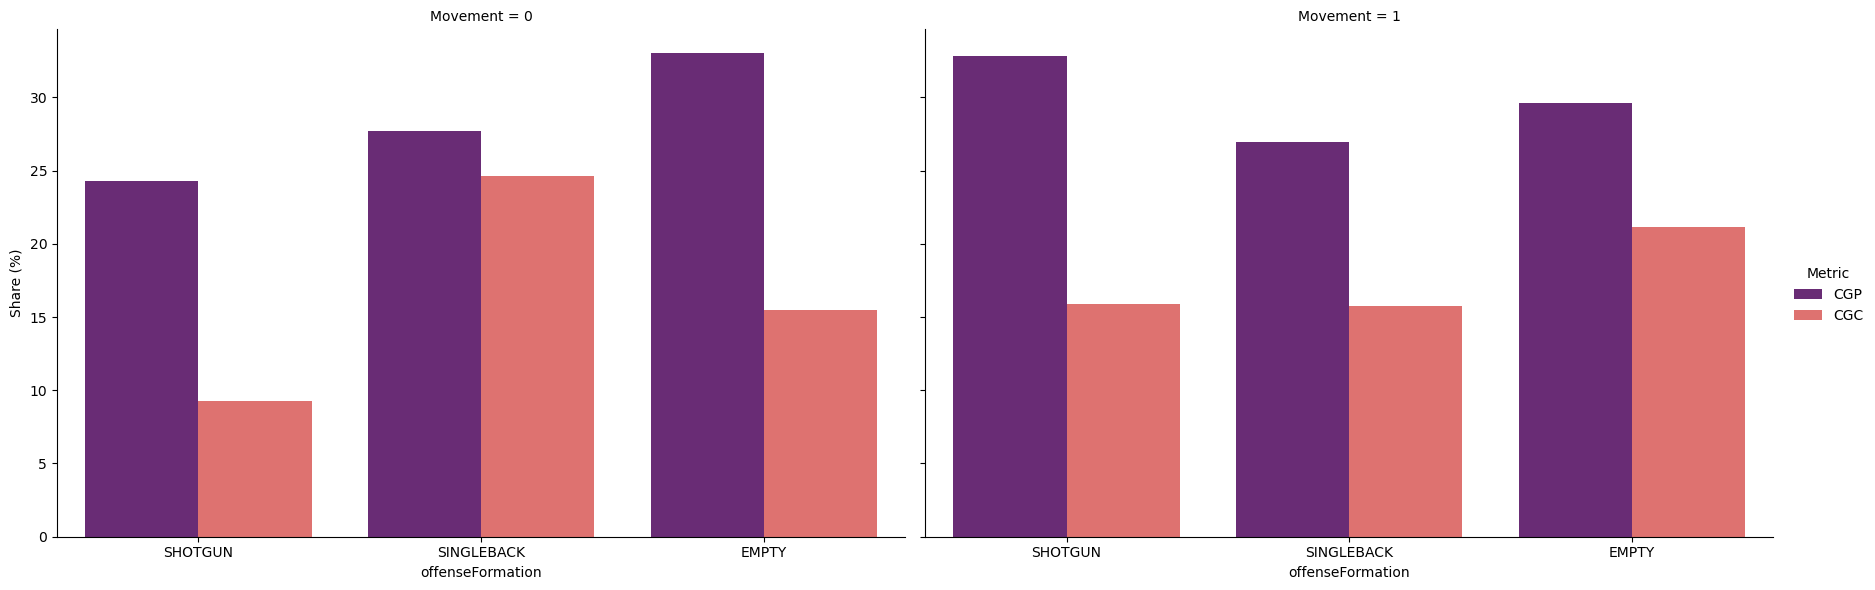

In [373]:
data = all_man.query(
    '60 > yardsGained > -20 and wasTargettedReceiver == 1 and offenseFormation.isin(["SHOTGUN", "SINGLEBACK", "EMPTY"])'
).groupby(['movement', 'offenseFormation'])[['coverageGap_pass', 'coverageGap_caught']].agg(share).reset_index()

data= data.melt(id_vars=['movement', 'offenseFormation'], var_name='Metric', value_name='Share')

data['Metric'] = data['Metric'].replace({'coverageGap_pass': 'CGP','coverageGap_caught': 'CGC'})

graph = sns.FacetGrid(data, col="movement", height=6, aspect=1.5, sharey=True)
graph.map(sns.barplot, "offenseFormation", "Share", "Metric", order=["SHOTGUN", "SINGLEBACK", "EMPTY"], palette="magma", ci=None)

graph.set_titles("Movement = {col_name}")
graph.set_axis_labels("offenseFormation", "Share (%)")
graph.add_legend(title="Metric")
plt.show()

graph.savefig("formations_share.png")

In [374]:
# data = all_man.query(
#     '60 > yardsGained > -20 and wasTargettedReceiver == 1 and offenseFormation.isin(["SHOTGUN", "SINGLEBACK", "EMPTY"])'
# ).groupby(['movement', 'offenseFormation'])[['coverageGap_pass', 'coverageGap_caught']].agg(share).reset_index()

# data= data.melt(id_vars=['movement', 'offenseFormation'], var_name='Metric', value_name='Share')

# data['Metric'] = data['Metric'].replace({'coverageGap_pass': 'CGP','coverageGap_caught': 'CGC'})

# graph = sns.FacetGrid(data, col="movement", height=6, aspect=1.5, sharey=True)
# graph.map(sns.barplot, "offenseFormation", "Share", "Metric", order=["SHOTGUN", "SINGLEBACK", "EMPTY"], palette="magma", ci=None)

# graph.set_titles("Movement = {col_name}")
# graph.set_axis_labels("Offense Formation", "Share (%)")
# graph.add_legend(title="Metric")
# plt.show()

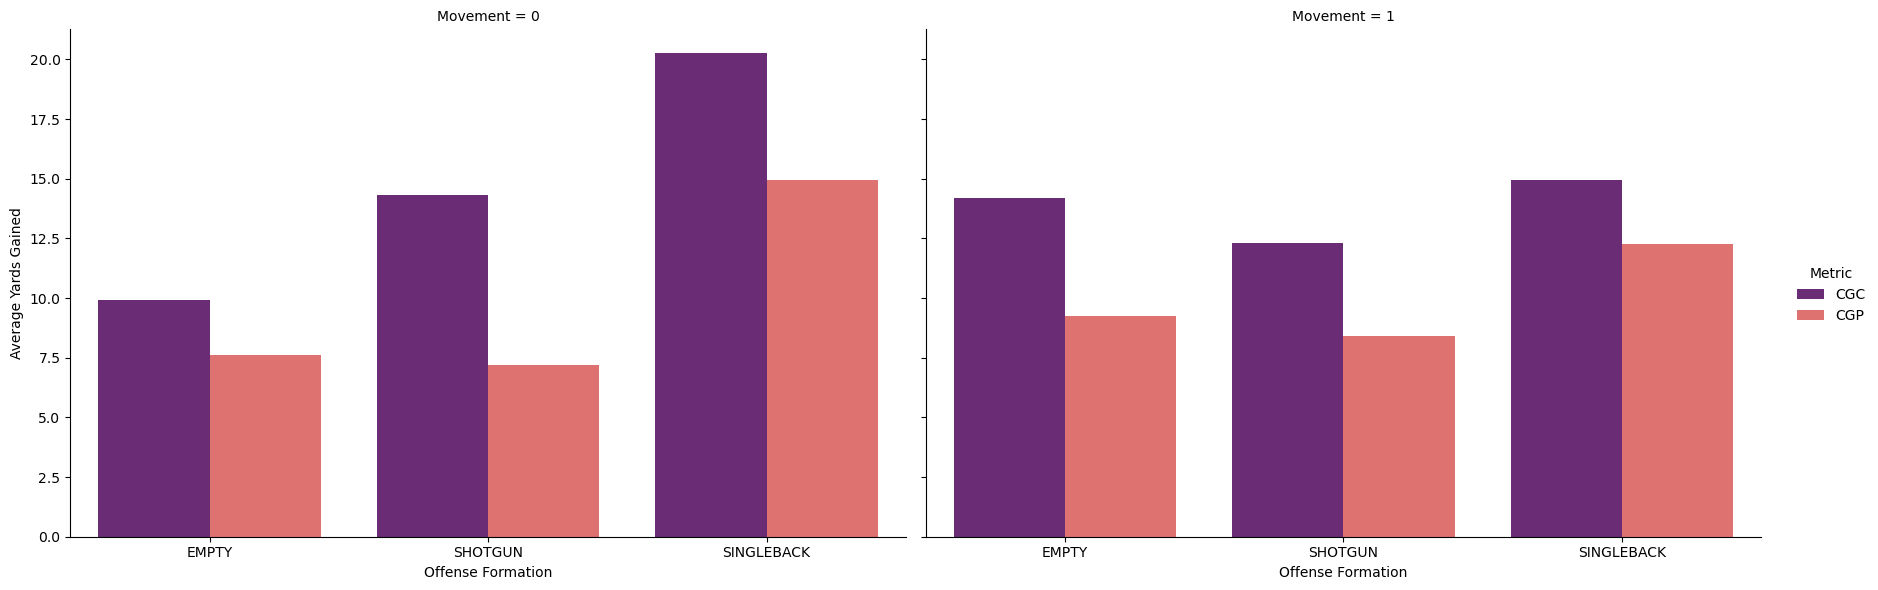

In [375]:
data = all_man.query(
    '60 > yardsGained > -20 and wasTargettedReceiver == 1 and offenseFormation.isin(["SHOTGUN", "SINGLEBACK", "EMPTY"]) and (coverageGap_pass == 1 or coverageGap_caught == 1)'
)

data = data.melt(id_vars=['movement', 'offenseFormation', 'yardsGained'], value_vars=['coverageGap_pass', 'coverageGap_caught'], 
    var_name='Metric', value_name='Coverage Gap').query('`Coverage Gap` == 1')
data['Metric'] = data['Metric'].replace({'coverageGap_pass': 'CGP','coverageGap_caught': 'CGC'})

data = data.groupby(['movement', 'offenseFormation', 'Metric'], as_index=False)['yardsGained'].mean()

graph = sns.catplot(data=data, kind="bar", x="offenseFormation", y="yardsGained", hue="Metric", col="movement", palette="magma",ci=None,
    height=6,aspect=1.5)
graph.set_titles("Movement = {col_name}")
graph.set_axis_labels("Offense Formation", "Average Yards Gained")
graph._legend.set_title("Metric")
graph.tight_layout()

plt.show()
graph.savefig("formations_yards.png")


In [186]:
all_man.query('60 > yardsGained>-20 and wasTargettedReceiver == 1 and ~routeRan.isin(["ANGLE"])'
             ).groupby(['routeRan', 'movement']).agg({'coverageGap_pass':['count', share],
                                                                    'coverageGap_caught':share, 'yardsGained': 'mean'})

coverageGap_pass        coverageGap_caught yardsGained
                             count  share              share        mean
routeRan movement                                                       
CORNER   0                      28  10.71               7.14    5.535714
         1                      24  12.50               8.33   10.875000
CROSS    0                      93  31.18              19.35    9.032258
         1                      98  47.96              29.59    8.530612
FLAT     0                      21  90.48              23.81    3.333333
         1                      25  64.00              36.00    5.240000
GO       0                     189   6.88               3.17   10.174603
         1                     103   3.88               2.91    7.320388
HITCH    0                      99  31.31               6.06    4.696970
         1                      64  40.62              12.50    7.015625
IN       0                      51  23.53              15.69    7.098039
         1                      58  27.59              10.34    8.586207
OUT      0                     101  41.58              15.84    5.237624
         1                      76  31.58              15.79    6.078947
POST     0                      47  12.77               6.38   12.510638
         1                      23  30.43              13.04   10.695652
SCREEN   0                      23  78.26              65.22    3.869565
         1                      29  58.62              55.17    5.413793
SLANT    0                     110  21.82               8.18    6.200000
         1                      69  21.74               4.35    5.913043

In [145]:
all_man = all_man.merge(plays[['gameId', 'playId', 'yardsToGo', 'distanceFromOwnEndZone']], on=['gameId', 'playId'])

In [194]:
for i in all_man.query('~routeRan.isin(["ANGLE"]) and routeRan.notna()')['routeRan'].unique():
    print('\033[94m' + 'route: {}'.format(i) + '\033[0m')
    z_test('coverageGap_pass', route=i)
    z_test('coverageGap_caught', route=i)
    print("\n\n")

route: OUT
column coverageGap_pass 0.173
(0.21128497282961584, 0.4202939745388052)
column coverageGap_caught 0.992
(0.07591466159351262, 0.2398748120906979)



route: CROSS
column coverageGap_pass 0.018
(0.38068120071358935, 0.5785024727557984)
column coverageGap_caught 0.101
(0.2055466528135738, 0.3862900818803038)



route: IN
column coverageGap_pass 0.629
(0.16083746750097566, 0.3908866704300588)
column coverageGap_caught 0.406
(0.02507222124464953, 0.1818243304794884)



route: HITCH
column coverageGap_pass 0.223
(0.28592479719609376, 0.5265752028039062)
column coverageGap_caught 0.152
(0.04397535497287143, 0.20602464502712858)



route: GO
column coverageGap_pass 0.296
(0.0015236973390243685, 0.07614620557359698)
column coverageGap_caught 0.902
(0.0, 0.061601491879755915)



route: SLANT
column coverageGap_pass 0.99
(0.12006797343177407, 0.3147146352638781)
column coverageGap_caught 0.318
(0.0, 0.09159620350281425)



route: CORNER
column coverageGap_pass 0.841
(0.0, 0.25731269127

 for the CROSS route, the share of gaps increases by 16.78 percentage points for coverageGap_pass and by 10.24 p.p for coverageGap_caught when motion is used. A Z-test confirms that this difference is statistically significant.
For the HITCH route, there is also a noticeable increase in coverageGap_pass by 9.31 percentage points with motion, highlighting the strategic advantage of motion in creating gaps.

There is a relationship between increased coverageGap_caught and average yards after the catch (yardageGainedAfterTheCatch). For instance, on the CROSS route, an increase in coverageGap_caught is associated with improved yards after the catch, confirming that the metric reflects the effectiveness of receivers against defenders.
For GO and CROSS routes, a reduction in coverageGap_pass without motion correlates with a decrease in the average number of yards gained, emphasizing the importance of motion in enhancing offensive outcomes.

In [206]:
for i in all_man.query('~routeRan.isin(["ANGLE"]) and routeRan.notna()')['routeRan'].unique():
    print('\033[94m' + 'rounte {}'.format(i) + '\033[0m')
    t_test('yardsGained', route=i)
    t_test('yardageGainedAfterTheCatch', route=i)
    print("\n")

rounte OUT
column yardsGained 0.425
column yardageGainedAfterTheCatch 0.586


rounte CROSS
column yardsGained 0.763
column yardageGainedAfterTheCatch 0.847


rounte IN
column yardsGained 0.465
column yardageGainedAfterTheCatch 0.109


rounte HITCH
column yardsGained 0.031
column yardageGainedAfterTheCatch 0.183


rounte GO
column yardsGained 0.106
column yardageGainedAfterTheCatch 0.031


rounte SLANT
column yardsGained 0.787
column yardageGainedAfterTheCatch 0.241


rounte CORNER
column yardsGained 0.129
column yardageGainedAfterTheCatch 0.26


rounte FLAT
column yardsGained 0.193
column yardageGainedAfterTheCatch 0.751


rounte SCREEN
column yardsGained 0.322
column yardageGainedAfterTheCatch 0.277


rounte POST
column yardsGained 0.655
column yardageGainedAfterTheCatch 0.76




C:\Users\Msi\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


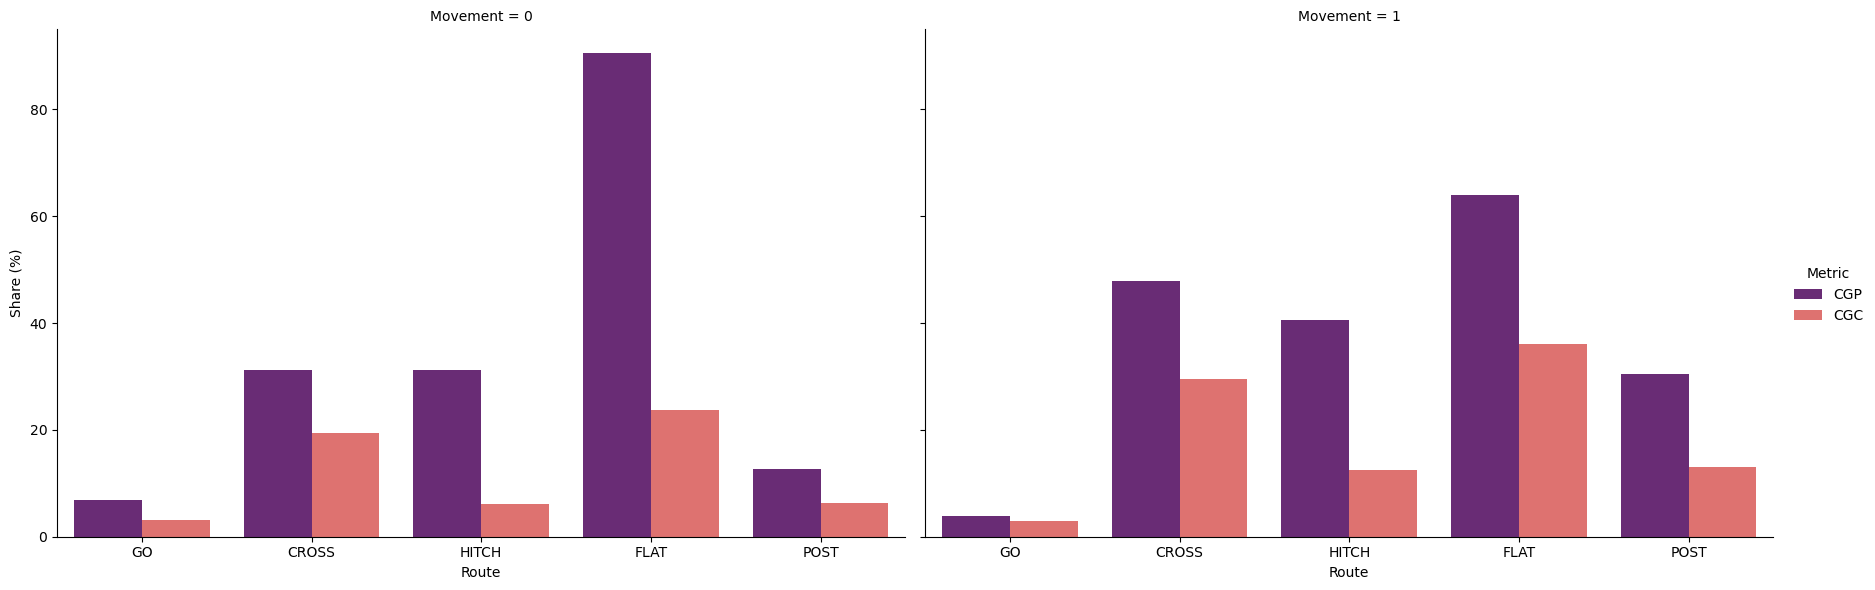

In [376]:
data = all_man.query(
    '60 > yardsGained > -20 and wasTargettedReceiver == 1 and routeRan.isin(["GO", "CROSS", "HITCH", "FLAT", "POST"])'
).groupby(['movement', 'routeRan'])[['coverageGap_pass', 'coverageGap_caught']].agg(share).reset_index()

data= data.melt(id_vars=['movement', 'routeRan'], var_name='Metric', value_name='Share')

data['Metric'] = data['Metric'].replace({'coverageGap_pass': 'CGP','coverageGap_caught': 'CGC'})

graph = sns.FacetGrid(data, col="movement", height=6, aspect=1.5, sharey=True)
graph.map(sns.barplot, "routeRan", "Share", "Metric", order=["GO", "CROSS", "HITCH", "FLAT", "POST"], palette="magma", ci=None)

graph.set_titles("Movement = {col_name}")
graph.set_axis_labels("Route", "Share (%)")
graph.add_legend(title="Metric")
graph.savefig("route_share.png")

plt.show()

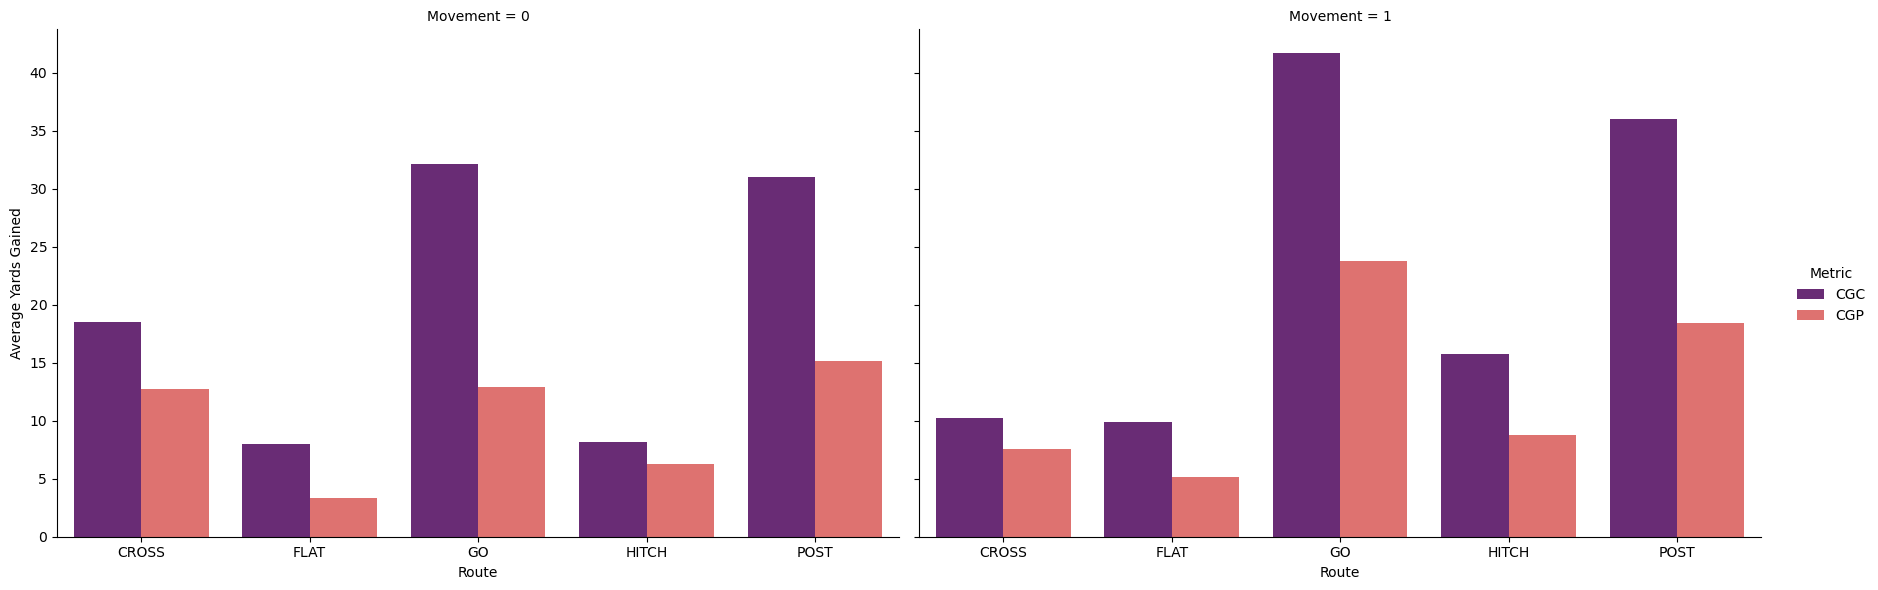

In [377]:
data = all_man.query(
    '60 > yardsGained > -20 and wasTargettedReceiver == 1 and routeRan.isin(["GO", "CROSS", "HITCH", "FLAT", "POST"]) and (coverageGap_pass == 1 or coverageGap_caught == 1)'
)

data = data.melt(id_vars=['movement', 'routeRan', 'yardsGained'], value_vars=['coverageGap_pass', 'coverageGap_caught'], 
    var_name='Metric', value_name='Coverage Gap').query('`Coverage Gap` == 1')
data['Metric'] = data['Metric'].replace({'coverageGap_pass': 'CGP','coverageGap_caught': 'CGC'})

data = data.groupby(['movement', 'routeRan', 'Metric'], as_index=False)['yardsGained'].mean()

g = sns.catplot(data=data, kind="bar", x="routeRan", y="yardsGained", hue="Metric", col="movement", palette="magma",ci=None,
    height=6,aspect=1.5)
g.set_titles("Movement = {col_name}")
g.set_axis_labels("Route", "Average Yards Gained")
g._legend.set_title("Metric")
g.tight_layout()
graph.savefig("route_yards.png")

plt.show()


Since we are considering the impact of presnap motions, coverageGap_pass is a more critical metric as it reflects how effectively the offense creates gaps before the ball is thrown. However, coverageGap_caught is also important because it captures the final gap and allows for an assessment of the defense's effectiveness in the outcome of the play.

In [208]:
all_man.query('60 > yardsGained>-20 and wasTargettedReceiver == 1 and ~receiverAlignment.isin(["1x1", "4x1"])'
             ).groupby(['receiverAlignment', 'movement']).agg({'coverageGap_pass':['count', share],
                                                                    'coverageGap_caught':share, 'yardsGained': 'mean'})

coverageGap_pass        coverageGap_caught  \
                                      count  share              share   
receiverAlignment movement                                              
2x1               0                      30  20.00              13.33   
                  1                      36  19.44              11.11   
2x2               0                     264  28.03              11.36   
                  1                     223  33.18              14.80   
3x1               0                     368  23.10              10.60   
                  1                     238  30.67              15.97   
3x2               0                      95  33.68              15.79   
                  1                      63  30.16              22.22   

                           yardsGained  
                                  mean  
receiverAlignment movement              
2x1               0           9.933333  
                  1           7.055556  
2x2               0           7.545455  
                  1           7.372197  
3x1               0           7.312500  
                  1           7.457983  
3x2               0           6.642105  
                  1           7.031746

In [325]:
for i in all_man.query('~receiverAlignment.isin(["1x1", "4x1", "2x0", "3x3"]) and receiverAlignment.notna()')['receiverAlignment'].unique():
    print('\033[94m' + 'receiverAlignment {}'.format(i) + '\033[0m')
    z_test('coverageGap_pass', alignment=i)
    z_test('coverageGap_caught', alignment=i)
    print("\n\n")

receiverAlignment 2x2
column coverageGap_pass 0.218
(0.2700369548183855, 0.39364017522645756)
column coverageGap_caught 0.26
(0.10137791541414842, 0.19458621014638972)



receiverAlignment 3x1
column coverageGap_pass 0.038
(0.24813773988531101, 0.36530763826594953)
column coverageGap_caught 0.053
(0.11312782260079501, 0.20619990849164194)



receiverAlignment 2x1
column coverageGap_pass 0.955
(0.0651611653598049, 0.32372772352908397)
column coverageGap_caught 0.783
(0.008451568566690507, 0.21377065365553172)



receiverAlignment 3x2
column coverageGap_pass 0.643
(0.18825847148330993, 0.4149161316912932)
column coverageGap_caught 0.306
(0.11956267967780161, 0.3248817647666428)





In [326]:
for i in all_man.query('~receiverAlignment.isin(["1x1", "4x1", "2x0", "3x3"]) and receiverAlignment.notna()')['receiverAlignment'].unique():
    print('\033[94m' + 'receiverAlignment {}'.format(i) + '\033[0m')
    t_test('yardsGained', alignment=i)
    t_test('yardageGainedAfterTheCatch', alignment=i)
    print("\n")

receiverAlignment 2x2
column yardsGained 0.862
column yardageGainedAfterTheCatch 0.375


receiverAlignment 3x1
column yardsGained 0.869
column yardageGainedAfterTheCatch 0.093


receiverAlignment 2x1
column yardsGained 0.376
column yardageGainedAfterTheCatch 0.397


receiverAlignment 3x2
column yardsGained 0.806
column yardageGainedAfterTheCatch 0.892




3x2 and 3x1 alignments show the highest coverageGap_pass values, with motion significantly increasing the proportion of gaps. Significant differences in coverageGap_pass and coverageGap_caught are found between 2x1 and 3x2. Alignments 2x2 and 3x2 show significant increases in yards after the catch, making them strategically advantageous for creating gaps and gaining yardage. Presnap motion increases coverageGap_pass across all alignments, with the strongest effects in 3x1 and 3x2.  3x2 shows the highest average yardage and gap proportions, highlighting the alignment's offensive efficiency.

With movement, mean yards gained is higher. Take a look at the passResult values:

In [365]:
all_man.query(
    '60 > yardsGained > -20 and wasTargettedReceiver == 1 and passResult != "NoPass"'
).groupby(['coverageGap_pass', 'movement'])['passResult'].apply(lambda x: (x == 'C').mean() * 100)

coverageGap_pass  movement
0                 0           43.362832
                  1           45.822785
1                 0           71.065990
                  1           80.000000
Name: passResult, dtype: float64

In [366]:
all_man.query(
    '60 > yardsGained > -20 and wasTargettedReceiver == 1 and passResult != "NoPass"'
).groupby(['coverageGap_caught', 'movement'])['passResult'].apply(lambda x: (x == 'C').mean() * 100)

coverageGap_caught  movement
0                   0            44.065282
                    1            48.016701
1                   0           100.000000
                    1           100.000000
Name: passResult, dtype: float64

In [370]:
df = all_man.query('receiverAlignment.isin(["3x1"]) and receiverAlignment.notna() and 60 > yardsGained > -20 and wasTargettedReceiver == 1 and passResult != "NoPass"')
df.groupby(['coverageGap_pass', 'movement'])['passResult'].apply(lambda x: (x == 'C').mean() * 100)
    

coverageGap_pass  movement
0                 0           44.169611
                  1           44.242424
1                 0           65.882353
                  1           78.082192
Name: passResult, dtype: float64

When the gap (coverageGap_pass) is greater than 3 yards, the completion rate increases, especially when there is movement (movement=1).